In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
from IPython.display import Audio
import pandas as pd

In [2]:
!pip install pyloudnorm

In [3]:
!pip install gdown
import gdown

# Load and play voice

In [4]:
#id of file in my google drive
file_id = '10ExNhT9CoqeYagSzH_7OzAsU3YsZWeVl'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'HW1-Q4-2-810103226-male.mp3', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=10ExNhT9CoqeYagSzH_7OzAsU3YsZWeVl
To: /content/HW1-Q4-2-810103226-male.mp3
100%|██████████| 639k/639k [00:00<00:00, 92.9MB/s]


'HW1-Q4-2-810103226-male.mp3'

In [5]:
# Load audio file
file_path = '/content/HW1-Q4-2-810103226-male.mp3'
y, sr = librosa.load(file_path)
print(f"sampling rate: {sr}")
# Play audio
display(Audio(y, rate=sr))

sampling rate: 22050


# bandpass filter for denoising

In [6]:
from scipy.signal import butter, filtfilt

def denoise_speech_bandpass(audio_data, sr, lowcut, highcut, order=5):
  """Denoises speech using a bandpass filter.

  Args:
    audio_data: The audio data as a NumPy array.
    sr: The sampling rate of the audio data.
    lowcut: The lower cutoff frequency of the bandpass filter.
    highcut: The upper cutoff frequency of the bandpass filter.
    order: The order of the bandpass filter.

  Returns:
    The denoised audio data as a NumPy array.
  """

  # Calculate Nyquist frequency
  nyq = 0.5 * sr

  # Normalize cutoff frequencies
  low = lowcut / nyq
  high = highcut / nyq

  # Design bandpass filter
  b, a = butter(order, [low, high], btype='band')

  # Apply filter
  denoised_audio = filtfilt(b, a, audio_data)

  return denoised_audio


# Remove Silence by adjusting threshold

In [7]:
def remove_silence(audio_data, sr, threshold=0.05, frame_length=4096, hop_length=512):
    """Removes silence from audio data.

    Args:
        audio_data: The audio data as a NumPy array.
        sr: The sampling rate of the audio data.
        threshold: The silence threshold (amplitude below this is considered silence).
        frame_length: The frame length for calculating RMS energy.
        hop_length: The hop length for calculating RMS energy.

    Returns:
        The audio data with silence removed, as a NumPy array.
    """

    # Calculate RMS energy for each frame
    rms = librosa.feature.rms(y=audio_data, frame_length=frame_length, hop_length=hop_length)[0]

    # Find frames above the threshold
    frames_above_threshold = np.where(rms > threshold)[0]

    # Initialize an empty list to store non-silent segments
    non_silent_segments = []

    # Iterate over frames above the threshold
    for i in range(len(frames_above_threshold)):
        # Get start and end samples for the current segment
        start_sample = frames_above_threshold[i] * hop_length
        end_sample = min((frames_above_threshold[i] + 1) * hop_length, len(audio_data))  # Prevent exceeding audio length

        # Append the current non-silent segment to the list
        non_silent_segments.append(audio_data[start_sample:end_sample])

    # Concatenate all non-silent segments
    if len(non_silent_segments) > 0:
      non_silent_audio = np.concatenate(non_silent_segments)
    else:
      non_silent_audio = audio_data

    return non_silent_audio

# Normalizae Loudness
target_lufs is typically lower than -10dB (Recommended: -14dB)

In [8]:
from pyloudnorm import Meter, normalize

def normalize_audio(audio_data, sr,  target_lufs=-14):
  """Normalizes all audio files in a directory to a target LUFS level."""
  # measure the loudness first
  meter = Meter(sr) # create BS.1770 meter
  loudness = meter.integrated_loudness(audio_data)

  # loudness normalize audio to target_lufs dB
  loudness_normalized_audio = normalize.loudness(audio_data, loudness, target_lufs)
  return loudness_normalized_audio

In [9]:
# Denoise the audio
y_denoised = denoise_speech_bandpass(y, sr, lowcut=100, highcut=8000, order=6)

display(Audio(y_denoised, rate=sr))

In [10]:
# Remove silence
non_silent_audio = remove_silence(y_denoised, sr, threshold=0.05, frame_length=4096, hop_length=512)
display(Audio(non_silent_audio, rate=sr))

In [11]:
# Example usage
y_normalized = normalize_audio(non_silent_audio, sr, -14)
display(Audio(y_normalized, rate=sr))

/usr/local/lib/python3.11/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


In [12]:
def preprocess_audio(audio_data, sr, duration = 5):
  y_denoised = denoise_speech_bandpass(audio_data, sr, lowcut=100, highcut=8000, order=6)
  y_normalized = normalize_audio(y_denoised, sr, -14)
  non_silent_audio = remove_silence(y_normalized, sr, threshold=0.05, frame_length=4096, hop_length=512)
  duration = sr*duration
  if len(non_silent_audio) > duration:
    non_silent_audio = non_silent_audio[0:duration]
  return non_silent_audio

#Plot

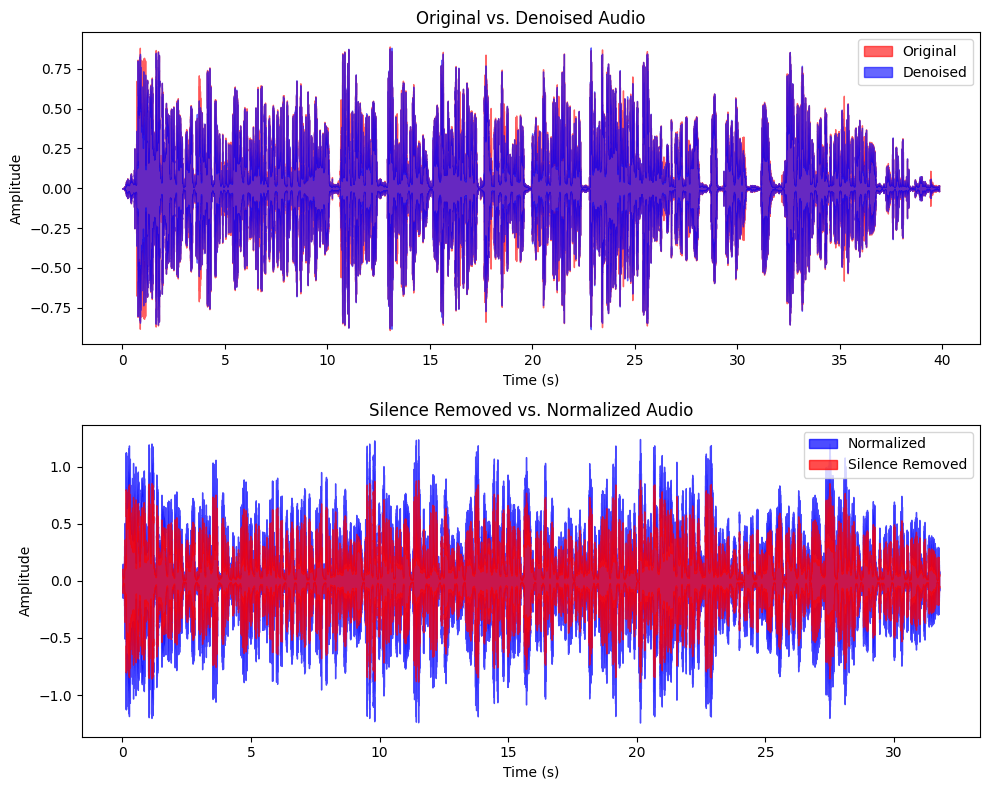

In [13]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axes with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # Adjust figsize as needed

# Plot original and denoised audio in the first subplot
librosa.display.waveshow(y, sr=sr, ax=axs[0], label='Original', alpha=0.6, color='red')
librosa.display.waveshow(y_denoised, sr=sr, ax=axs[0], label='Denoised', alpha=0.6, color='blue')


axs[0].set_title('Original vs. Denoised Audio')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].legend()

# Plot silence removed and normalized audio in the second subplot
librosa.display.waveshow(y_normalized, sr=sr, ax=axs[1], label='Normalized', alpha=0.7, color='blue')
librosa.display.waveshow(non_silent_audio, sr=sr, ax=axs[1], label='Silence Removed', alpha=0.7, color='red')
axs[1].set_title('Silence Removed vs. Normalized Audio')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


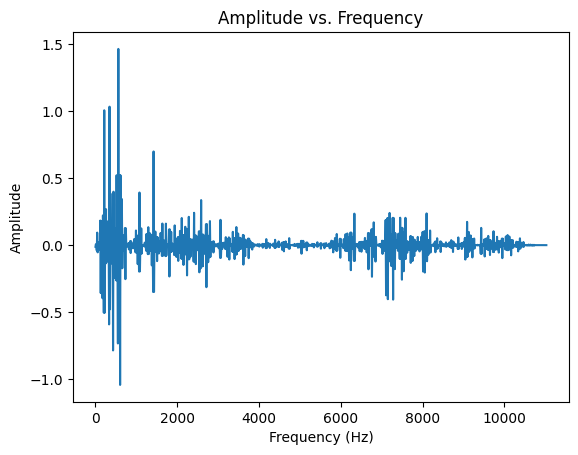

In [14]:
# Calculate STFT
D = librosa.stft(y[0:sr*10])

# Convert to amplitude spectrum
magnitude = np.abs(D)
# Get frequencies corresponding to the STFT bins
frequencies = librosa.fft_frequencies(sr=sr)

# Average amplitude across time frames
average_amplitude = np.mean(D, axis=1)

# Plot amplitude vs. frequency
plt.plot(frequencies, average_amplitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Amplitude vs. Frequency')
plt.show()

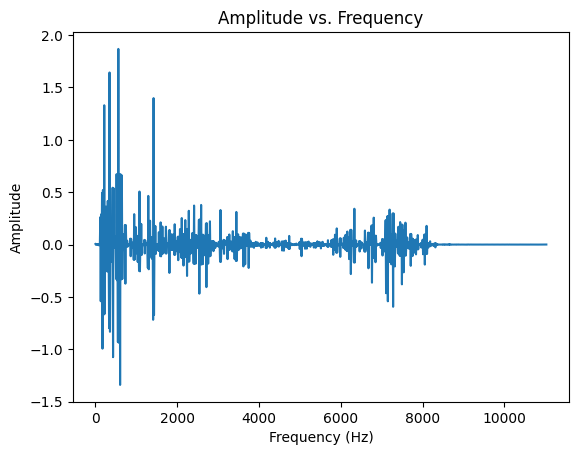

In [15]:
# Calculate STFT
D2 = librosa.stft(y_normalized[0:sr*10])

# Convert to amplitude spectrum
magnitude = np.abs(D)
# Get frequencies corresponding to the STFT bins
frequencies = librosa.fft_frequencies(sr=sr)

# Average amplitude across time frames
average_amplitude = np.mean(D2, axis=1)

# Plot amplitude vs. frequency
plt.plot(frequencies, average_amplitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Amplitude vs. Frequency')
plt.show()